<b>Домашнее задание:</b> Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений.

******

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

****

In [4]:
# загружаем данные
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=13)

In [5]:
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

def get_log_loss(pred_proba, y):
    return -np.sum(y*np.log2(pred_proba)+(1-y)*np.log2(1-pred_proba))/len(y)

def accuracy_report(e, title):
    print(f'{title}. Точность модели adaboost: {round((1-e)*100, 3)}')

In [6]:
def adaboost(X, y, N, base_alg="dtc"):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        if base_alg == "dtc":
            clf = DecisionTreeClassifier(max_depth=1)
        if base_alg == "lrc":
            clf = LogisticRegression()
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        y_pred_proba = clf.predict_proba(X)[:, 1] 
        
        if base_alg == "dtc":
            e = get_error(predictions, y)
        if base_alg == "lrc":
            e = get_log_loss(y_pred_proba, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes:
            next

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[np.logical_not(match)] *= np.exp(alpha)
        w[match] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))

    return models

def predict(X, models, n_classes = 2):
    
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred


****************

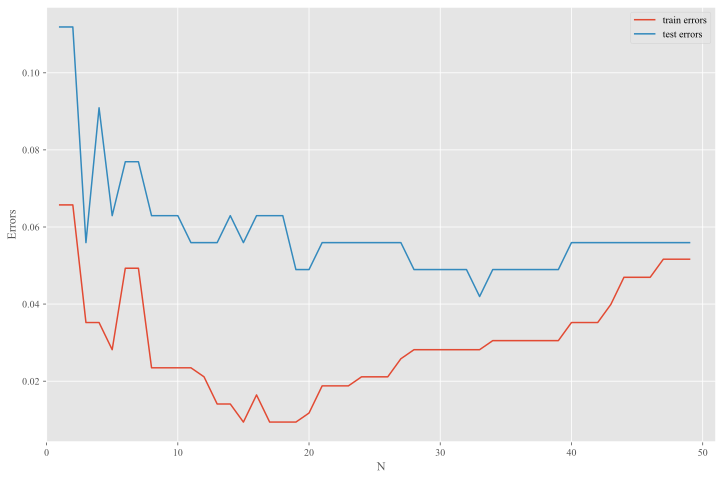

In [7]:
# проверим работу с использованием базового алгоритма - дерева решенией
train_errors = []
test_errors = []

for n in range(1, 50):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 50))

plt.figure(figsize=(12, 8))
plt.xlim(0, 51)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')
plt.show()

In [8]:
# минимальная доля ошибок на тесте при количестве итераций = 33
N = 33
models = adaboost(X_train, y_train, N)
accuracy_report(get_error(predict(X_test, models), y_test), 'Дерево решений в качестве базового алгоритма')


Дерево решений в качестве базового алгоритма. Точность модели adaboost: 95.804


***

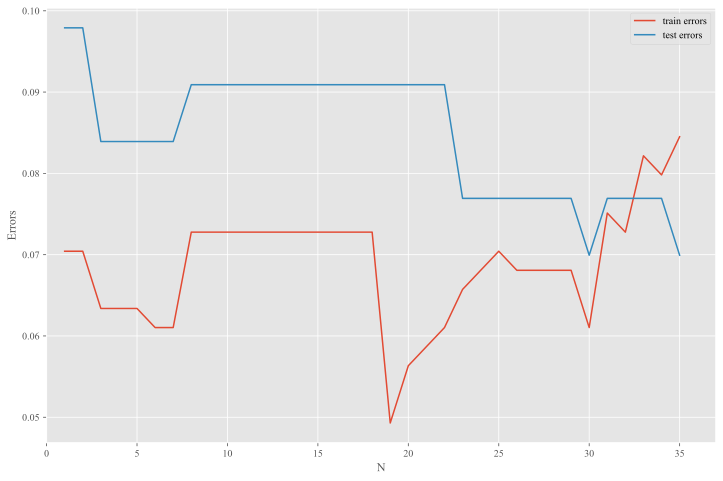

In [9]:
# проверим работу с использованием базового алгоритма - логистической регрессии
train_errors = []
test_errors = []

for n in range(1, 36):
    mods = adaboost(X_train, y_train, n, base_alg='lrc')
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 36))

plt.figure(figsize=(12, 8))
plt.xlim(0, 37)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Errors')
plt.legend(loc='upper right')
plt.show()

In [10]:
# минимальная доля ошибок на тесте при количестве итераций = 30
N = 30
models = adaboost(X_train, y_train, N)
accuracy_report(get_error(predict(X_test, models), y_test), 'Логистическая регрессия в качестве базового алгоритма')


Логистическая регрессия в качестве базового алгоритма. Точность модели adaboost: 95.105
